# Imports

In [1]:
import optuna
import mlflow
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import mlflow.sklearn
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Gerando as funções de treinamento

In [2]:
def remove_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    cols = df.select_dtypes(exclude='number').columns
    for cols in cols:
        df[cols] = df[cols].astype('category').cat.codes
    return df

In [3]:
def train_linear_regression(df_train: pd.DataFrame, df_val: pd.DataFrame, test_name: str) -> None:
    print(f"LINEAR REGRESSION: {test_name:^20}")

    df_train = remove_categorical_columns(df_train).dropna()
    df_val = remove_categorical_columns(df_val).dropna()

    X_train, y_train = df_train.drop(columns=["Next Week's Deaths"]), df_train["Next Week's Deaths"]
    X_val, y_val = df_val.drop(columns=["Next Week's Deaths"]), df_val["Next Week's Deaths"]

    LinearRegressionParams = {
        "fit_intercept": [True, False],
        "copy_X": [True, False]
    }

    def objective(trial):
        model_params = {key: trial.suggest_categorical(key, values) for key, values in LinearRegressionParams.items()}

        with mlflow.start_run():
            model = LinearRegression(**model_params, n_jobs=-1)
            model.fit(X_train, y_train)

            # Fazer previsões e calcular o erro quadrático médio
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)

            # Registrar os parâmetros e métricas no MLflow
            for key, value in model_params.items():
                mlflow.log_param(key, value)

            mlflow.log_metric('mse', mse)
            mlflow.sklearn.log_model(model, 'model')
            return mse

    # Configurar e executar a otimização do Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    print('Melhores hiperparâmetros:', study.best_params)
    print('Melhor valor objetivo:', study.best_value)

    study.trials_dataframe().to_csv(f'../data/LinearRegressionParams_{test_name}_study.csv')

In [9]:
def train_ridge(df_train: pd.DataFrame, df_val: pd.DataFrame, test_name: str) -> None:
    print(f"RIDGE: {test_name:^20}")

    df_train = remove_categorical_columns(df_train).dropna()
    df_val = remove_categorical_columns(df_val).dropna()

    X_train, y_train = df_train.drop(columns=["Next Week's Deaths"]), df_train["Next Week's Deaths"]
    X_val, y_val = df_val.drop(columns=["Next Week's Deaths"]), df_val["Next Week's Deaths"]

    RidgeRegressionParams = {
        "alpha": [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1000],
        "fit_intercept": [True, False],
        "copy_X": [True, False],
        "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]
    }

    def objective(trial):
        model_params = {key: trial.suggest_categorical(key, values) for key, values in RidgeRegressionParams.items()}

        with mlflow.start_run():
            model = Ridge(**model_params, random_state=42)
            model.fit(X_train, y_train)

            # Fazer previsões e calcular o erro quadrático médio
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)

            # Registrar os parâmetros e métricas no MLflow
            for key, value in model_params.items():
                mlflow.log_param(key, value)

            mlflow.log_metric('mse', mse)
            mlflow.sklearn.log_model(model, 'model')

            return mse

    # Configurar e executar a otimização do Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    print('Melhores hiperparâmetros:', study.best_params)
    print('Melhor valor objetivo:', study.best_value)

    study.trials_dataframe().to_csv(f'../data/Ridge_{test_name}_study.csv')

In [10]:
def train_SVR(df_train: pd.DataFrame, df_val: pd.DataFrame, test_name: str) -> None:
    print(f"SVR: {test_name:^20}")

    df_train = remove_categorical_columns(df_train).dropna()
    df_val = remove_categorical_columns(df_val).dropna()

    X_train, y_train = df_train.drop(columns=["Next Week's Deaths"]), df_train["Next Week's Deaths"]
    X_val, y_val = df_val.drop(columns=["Next Week's Deaths"]), df_val["Next Week's Deaths"]

    SVRParams = {
        "C": [0.01, 0.1, 1, 10, 100],
        "kernel": ["linear", "rbf"],
        "degree": [2, 3, 5],
        "gamma": ["scale", "auto"],
        "coef0": [0.0, 0.5, 1.0, 5.0]
    }

    def objective(trial):
        model_params = {key: trial.suggest_categorical(key, values) for key, values in SVRParams.items()}

        with mlflow.start_run():
            # Limitando pois é um treinamento demorado
            model = SVR(**model_params, max_iter=1000)
            model.fit(X_train, y_train)

            # Fazer previsões e calcular o erro quadrático médio
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)

            # Registrar os parâmetros e métricas no MLflow
            for key, value in model_params.items():
                mlflow.log_param(key, value)

            mlflow.log_metric('mse', mse)
            mlflow.sklearn.log_model(model, 'model')
            return mse

    # Configurar e executar a otimização do Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    print('Melhores hiperparâmetros:', study.best_params)
    print('Melhor valor objetivo:', study.best_value)

    study.trials_dataframe().to_csv(f'../data/SVR_{test_name}_study.csv')

In [11]:
def train_RandomForestRegressor(df_train: pd.DataFrame, df_val: pd.DataFrame, test_name: str) -> None:
    print(f"RANDOM FOREST: {test_name:^20}")

    df_train = remove_categorical_columns(df_train).dropna()
    df_val = remove_categorical_columns(df_val).dropna()

    X_train, y_train = df_train.drop(columns=["Next Week's Deaths"]), df_train["Next Week's Deaths"]
    X_val, y_val = df_val.drop(columns=["Next Week's Deaths"]), df_val["Next Week's Deaths"]

    RandomForestRegressorParams = {
        "n_estimators": [10, 50, 100, 200, 500],
        "max_depth": [None, 5, 10, 20, 50],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2"],
        "bootstrap": [True, False]
    }

    def objective(trial):
        model_params = {key: trial.suggest_categorical(key, values) for key, values in RandomForestRegressorParams.items()}

        with mlflow.start_run():
            model = RandomForestRegressor(**model_params, n_jobs=-1, random_state=42)
            model.fit(X_train, y_train)

            # Fazer previsões e calcular o erro quadrático médio
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)

            # Registrar os parâmetros e métricas no MLflow
            for key, value in model_params.items():
                mlflow.log_param(key, value)

            mlflow.log_metric('mse', mse)
            mlflow.sklearn.log_model(model, 'model')
            return mse

    # Configurar e executar a otimização do Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    print('Melhores hiperparâmetros:', study.best_params)
    print('Melhor valor objetivo:', study.best_value)

    study.trials_dataframe().to_csv(f'../data/RandomForestRegressor_{test_name}_study.csv')

# Treinando

In [12]:
datasets = [
    "df_preprocessed",
    "df_preprocessed_normalized",
    "df"
]

In [14]:
for dataset in datasets:
    for i in ["train", "val", "test"]:
        df = pd.read_csv(f"../data/{dataset}_{i}.csv")
        if "Unnamed: 0" in df.columns:
            df = df.drop(columns=["Unnamed: 0"])
        if i == "train":
            df_train = df
        elif i == "val":
            df_val = df
        else:
            continue
    train_linear_regression(df_train, df_val, dataset)
    train_ridge(df_train, df_val, dataset)
    if "normalized" in dataset:
        train_SVR(df_train, df_val, dataset)
    train_RandomForestRegressor(df_train, df_val, dataset)

LINEAR REGRESSION:   df_preprocessed   
Melhores hiperparâmetros: {'fit_intercept': True, 'copy_X': True}
Melhor valor objetivo: 5166339.688033756
RIDGE:   df_preprocessed   


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.86433e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.8609e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.8609e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.41748e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.8609e-25): result may not be accurate.
 

Melhores hiperparâmetros: {'alpha': 0.01, 'fit_intercept': True, 'copy_X': True, 'solver': 'svd'}
Melhor valor objetivo: 5167832.978093622
RANDOM FOREST:   df_preprocessed   
Melhores hiperparâmetros: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}
Melhor valor objetivo: 405759.7960547484
LINEAR REGRESSION: df_preprocessed_normalized
Melhores hiperparâmetros: {'fit_intercept': False, 'copy_X': True}
Melhor valor objetivo: 0.11939708607124214
RIDGE: df_preprocessed_normalized
Melhores hiperparâmetros: {'alpha': 0.001, 'fit_intercept': False, 'copy_X': False, 'solver': 'cholesky'}
Melhor valor objetivo: 0.11901792183869224
SVR: df_preprocessed_normalized


/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solv

Melhores hiperparâmetros: {'C': 10, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'coef0': 0.5}
Melhor valor objetivo: 0.03385165712762756
RANDOM FOREST: df_preprocessed_normalized
Melhores hiperparâmetros: {'n_estimators': 200, 'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}
Melhor valor objetivo: 0.01981833372073103
LINEAR REGRESSION:          df         
Melhores hiperparâmetros: {'fit_intercept': True, 'copy_X': False}
Melhor valor objetivo: 1070991.7884971937
RIDGE:          df         


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.47579e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.3174e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.40022e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.40022e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.37583e-21): result may not be accurate.

Melhores hiperparâmetros: {'alpha': 10, 'fit_intercept': True, 'copy_X': True, 'solver': 'cholesky'}
Melhor valor objetivo: 1070846.4398777047
RANDOM FOREST:          df         
Melhores hiperparâmetros: {'n_estimators': 10, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}
Melhor valor objetivo: 206860.40812426605


Olhando as os melhores resultados dos modelos, em geral, pode-se descartar a solução não normalizada.
O melhor modelo de cada algorítmo foi:

 - Linear regression:
    - Melhores hiperparâmetros: {'fit_intercept': False, 'copy_X': True}
    - Melhor valor objetivo: 0.11939708607124214
 - Ridge:
    - Melhores hiperparâmetros: {'alpha': 0.001, 'fit_intercept': False, 'copy_X': False, 'solver': 'cholesky'}
    - Melhor valor objetivo: 0.11901792183869224
 - SVR:
    - Melhores hiperparâmetros: {'C': 10, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'coef0': 0.5}
    - Melhor valor objetivo: 0.03385165712762756
 - Random Forest:
    - Melhores hiperparâmetros: {'n_estimators': 200, 'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}
    - Melhor valor objetivo: 0.01981833372073103

# Scatter plot com clustering

In [15]:
df_train = pd.read_csv("../data/df_preprocessed_normalized_train.csv").drop(columns=["Unnamed: 0"])
df_test = pd.read_csv("../data/df_preprocessed_normalized_test.csv").drop(columns=["Unnamed: 0"])
df_val = pd.read_csv("../data/df_preprocessed_normalized_val.csv").drop(columns=["Unnamed: 0"])

df_train = remove_categorical_columns(df_train).dropna()
df_test = remove_categorical_columns(df_test).dropna()
df_val = remove_categorical_columns(df_val).dropna()

In [16]:
len(df_train.columns)

21

In [17]:
df = df_train.copy()

In [18]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(df.drop(columns=["Next Week's Deaths"]))
df["cluster"] = clusters

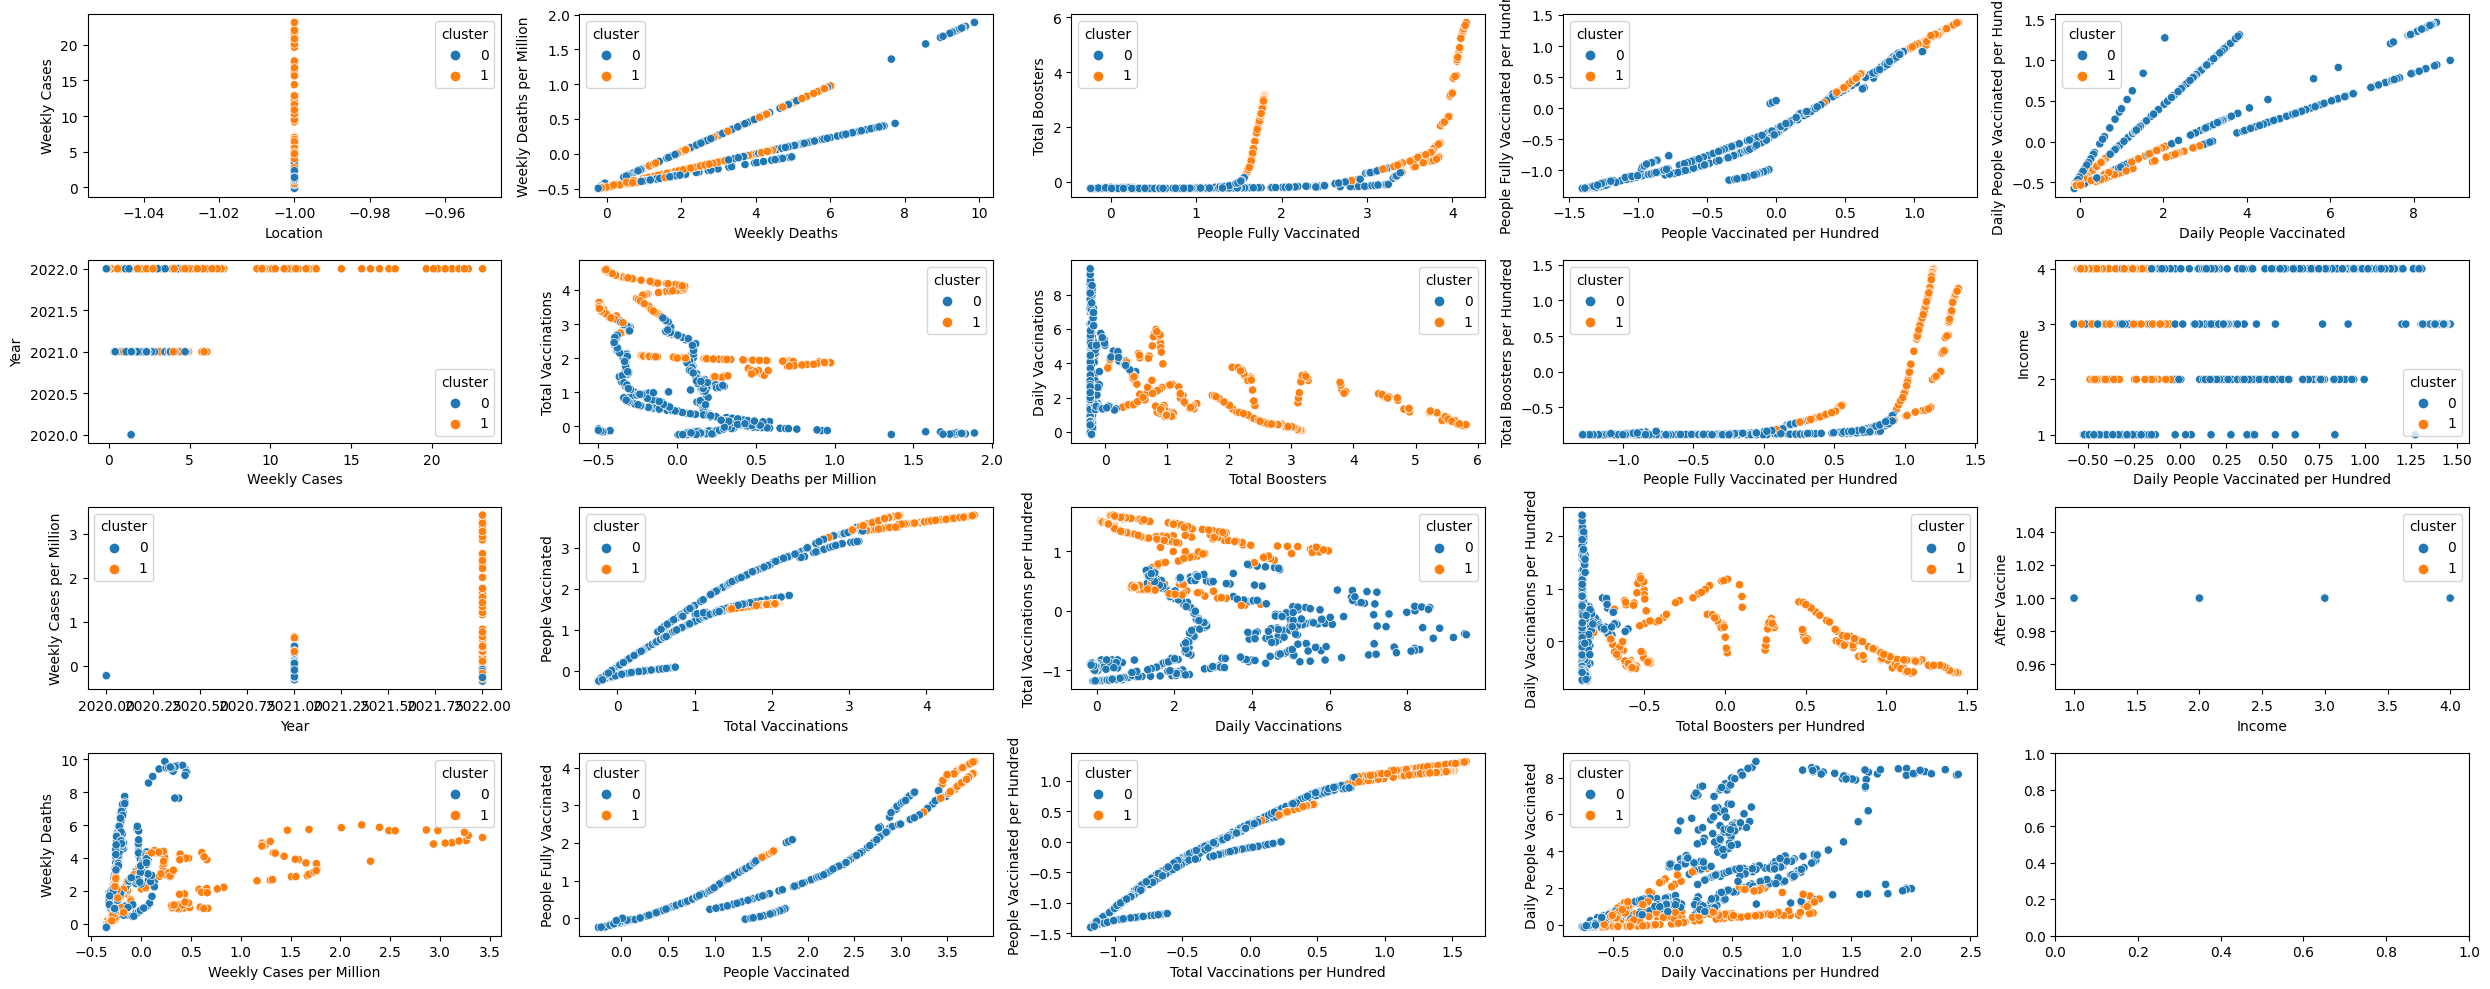

In [19]:
figs, axes = plt.subplots(4,5,figsize=(25,10))
i, j = 0, 0
cols = df_train.drop(columns=["Next Week's Deaths"]).columns
for idx in range(len(cols)-1):
    sns.scatterplot(data=df, x=cols[idx], y=cols[idx + 1], hue='cluster', ax=axes[i, j])
    i+=1
    if i == 4:
        i = 0
        j+=1
plt.tight_layout()

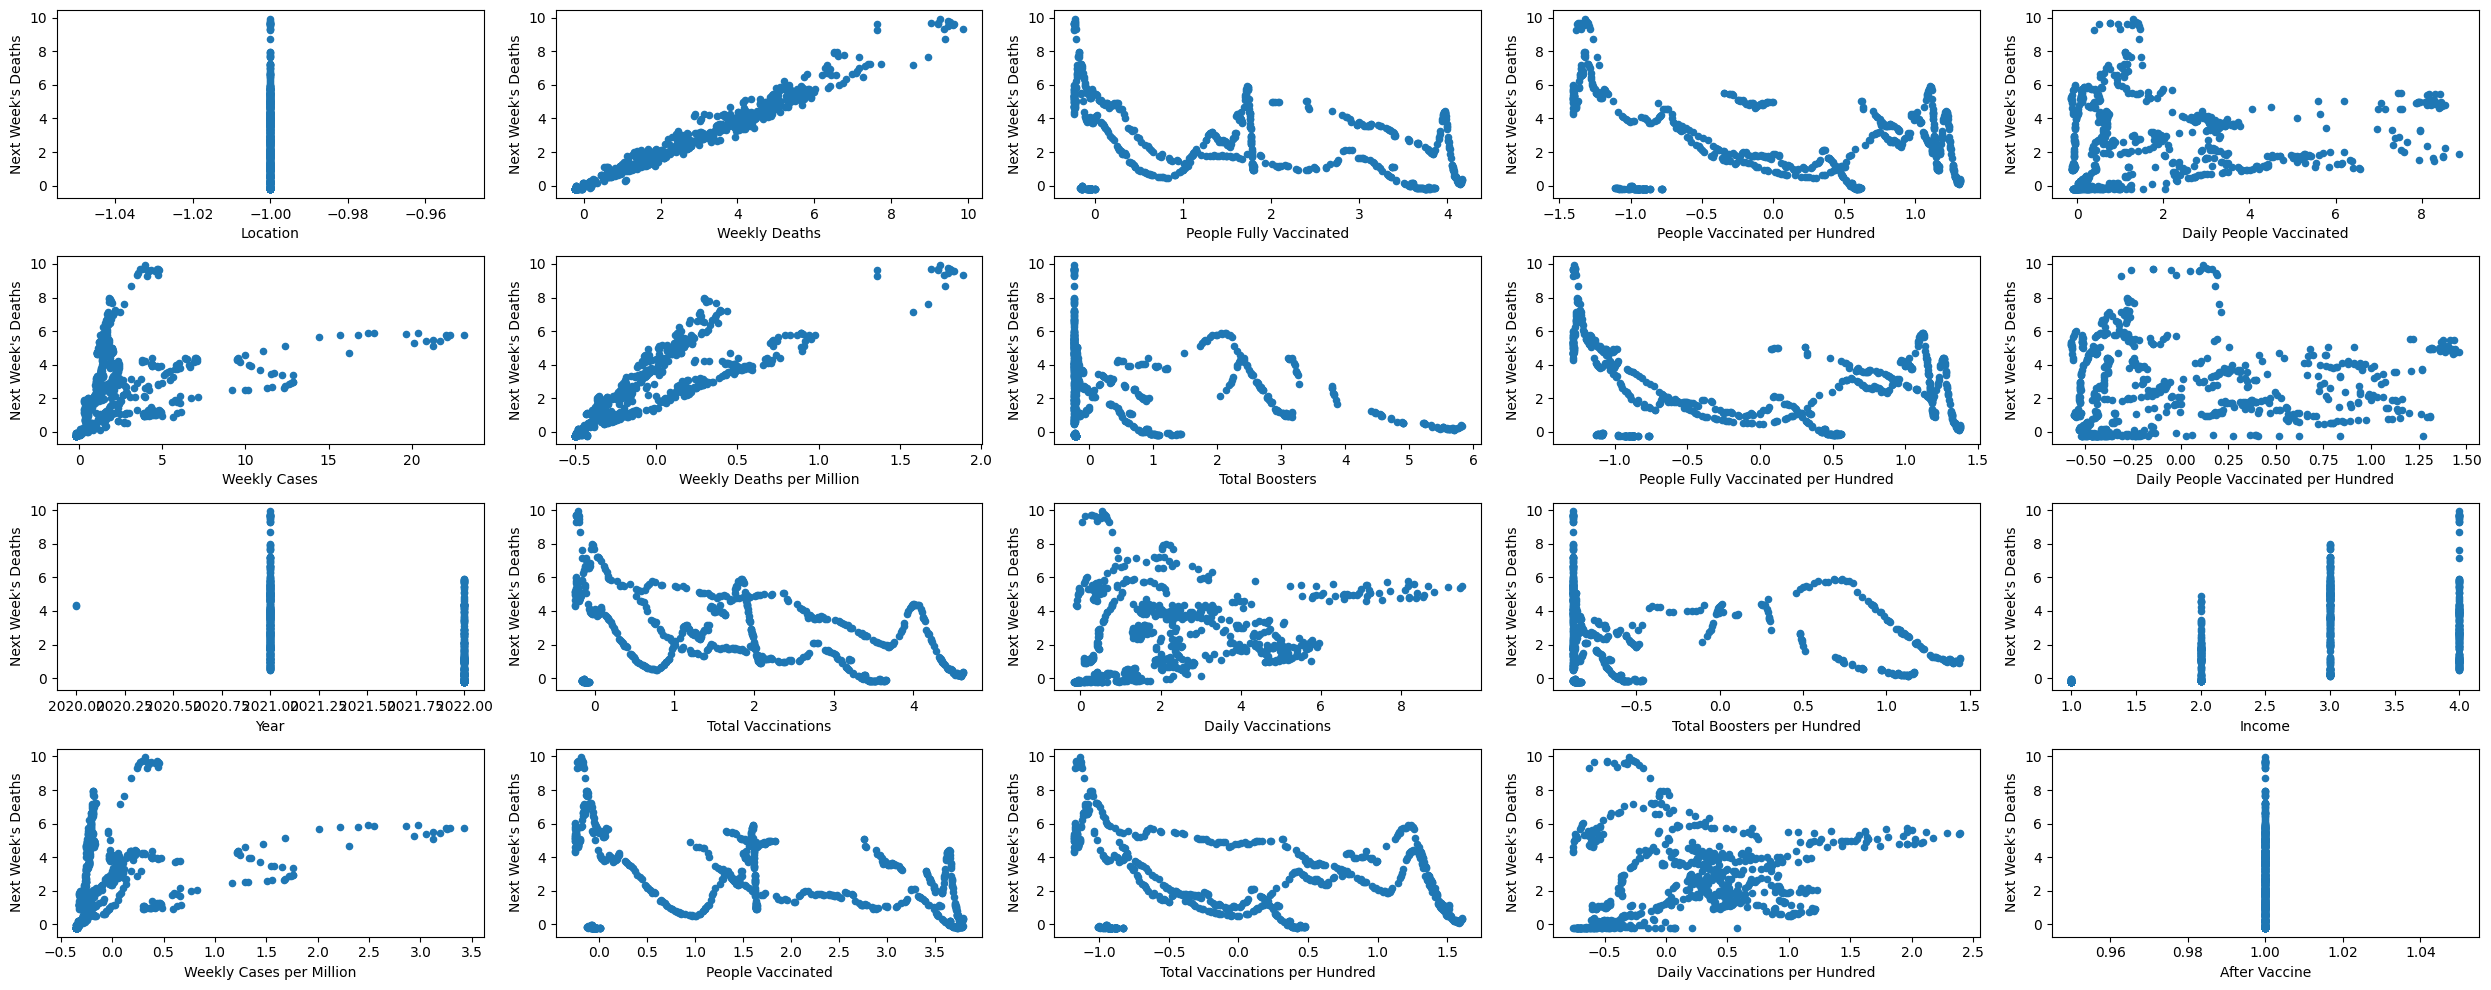

In [22]:
figs, axes = plt.subplots(4,5,figsize=(25,10))
i, j = 0, 0
for col in df_train.drop(columns=["Next Week's Deaths"]).columns:
    df_train[[col, "Next Week's Deaths"]].plot.scatter(x=col, y="Next Week's Deaths", ax=axes[i, j])
    i+=1
    if i == 4:
        i = 0
        j+=1
plt.tight_layout()

# Escolhendo o Melhor modelo pelo conjunto de teste

In [23]:
X_train, y_train = df_train.drop(columns=["Next Week's Deaths"]), df_train["Next Week's Deaths"]
X_test, y_test = df_test.drop(columns=["Next Week's Deaths"]), df_test["Next Week's Deaths"]
X_val, y_val = df_val.drop(columns=["Next Week's Deaths"]), df_val["Next Week's Deaths"]

### Linear Regression

In [24]:
lr_model = LinearRegression(**{'fit_intercept': False, 'copy_X': True}, n_jobs=-1)
lr_model.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]))
y_pred = lr_model.predict(X_val)
lr_mse_val = mean_squared_error(y_val, y_pred)

y_pred = lr_model.predict(X_test)
lr_mse_test = mean_squared_error(y_test, y_pred)

lr_mse_val, lr_mse_test

(0.11283039073219943, 0.10737675418764397)

O erro no treinamento do Linear Regression foi de aproximadamente 11.28% e no conjunto de teste foi de 10.74%, o que sugere uma baixa variância mas um alto viés, o que significa que essa não é uma boa arquitetura para resolver esse problema.

### Ridge

In [25]:
ridge_model = Ridge(**{'alpha': 0.001, 'fit_intercept': False, 'copy_X': False, 'solver': 'cholesky'}, random_state=42)
ridge_model.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]))
y_pred = ridge_model.predict(X_val)
ridge_mse_val = mean_squared_error(y_val, y_pred)

y_pred = ridge_model.predict(X_test)
ridge_mse_test = mean_squared_error(y_test, y_pred)

ridge_mse_val, ridge_mse_test

(0.11288680923735196, 0.10751777674073723)

O erro no treinamento do Ridge foi de aproximadamente 11.28% e no conjunto de teste foi de 10.75%, o que sugere uma baixa variância mas um alto viés, o que significa que essa não é uma boa arquitetura para resolver esse problema.

### SVR

In [26]:
svr_model = SVR(**{'C': 10, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'coef0': 0.0})
svr_model.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]))
y_pred = svr_model.predict(X_val)
svr_mse_val = mean_squared_error(y_val, y_pred)

y_pred = svr_model.predict(X_test)
svr_mse_test = mean_squared_error(y_test, y_pred)

svr_mse_val, svr_mse_test

(0.01983969098854786, 0.020182696508316535)

O erro no treinamento do SVR foi de aproximadamente 1.98% e no conjunto de teste foi de 2.18%, o que sugere uma baixa variância mas um baixo viés, o que significa que essa é uma boa arquitetura para resolver esse problema.

### Random Forest

In [27]:
rf_model = RandomForestRegressor(**{'n_estimators': 200, 'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}, random_state=42, n_jobs=-1)
rf_model.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]))
y_pred = rf_model.predict(X_val)
rf_mse_val = mean_squared_error(y_val, y_pred)

y_pred = rf_model.predict(X_test)
rf_mse_test = mean_squared_error(y_test, y_pred)

rf_mse_val, rf_mse_test

(0.0009964616376863134, 0.01345348392448237)

O erro no treinamento do Random Forest foi de aproximadamente 0.1% e no conjunto de teste foi de 1.3%, o que sugere uma baixa variância mas um baixo viés, o que significa que essa é uma boa arquitetura para resolver esse problema.

Tanto o Random Forest quanto o SVR possuem boas perfomances e podem resolver o problema, abaixo está uma comparação mais detalhada para decidirmos qual modelo será deployado.

# Cross validation

In [28]:
def collect_errors(model, X, y, X_test, y_test):
    errors_val, errors_test = [], []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        errors_val.append(mse)

        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        errors_test.append(mse)

    return errors_val, errors_test

In [31]:
rf_model = RandomForestRegressor(**{'n_estimators': 200, 'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}, random_state=42, n_jobs=-1)
svr_model = SVR(**{'C': 10, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'coef0': 0.0})

svr_errors_val, svr_errors_test = collect_errors(svr_model, np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]), X_test, y_test)
rf_errors_val, rf_errors_test = collect_errors(rf_model, np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]), X_test, y_test)

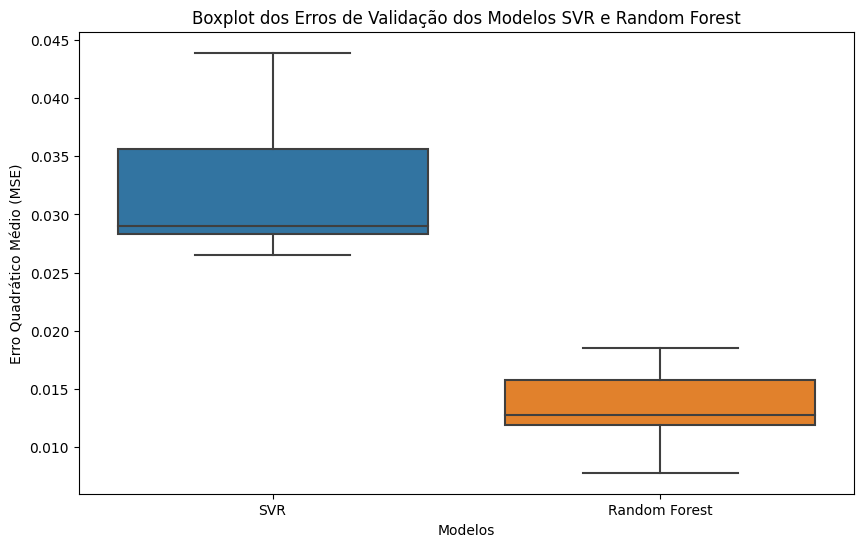

In [32]:
errors_df = pd.DataFrame({
    'SVR': svr_errors_val,
    'Random Forest': rf_errors_val
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=errors_df)
plt.title('Boxplot dos Erros de Validação dos Modelos SVR e Random Forest')
plt.ylabel('Erro Quadrático Médio (MSE)')
plt.xlabel('Modelos')
plt.show()

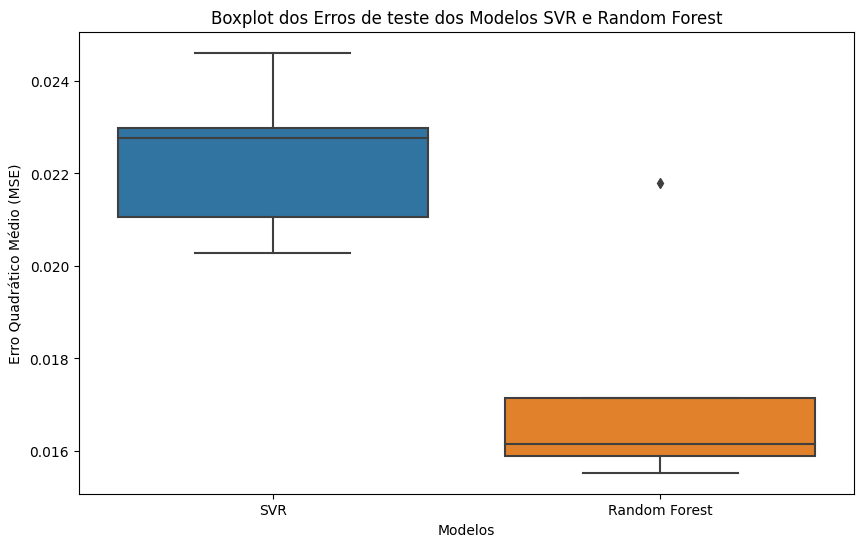

In [33]:
errors_df = pd.DataFrame({
    'SVR': svr_errors_test,
    'Random Forest': rf_errors_test
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=errors_df)
plt.title('Boxplot dos Erros de teste dos Modelos SVR e Random Forest')
plt.ylabel('Erro Quadrático Médio (MSE)')
plt.xlabel('Modelos')
plt.show()

Assim, nota-se que o Random Forest é o melhor modelo.

# Salvando o melhor modelo

In [34]:
rf_model = RandomForestRegressor(**{'n_estimators': 200, 'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}, random_state=42, n_jobs=-1)
rf_model.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]))

RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      min_samples_split=5, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [35]:
joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [36]:
df_test.sample(n=1)

,Location,Weekly Cases,Year,Weekly Cases per Million,Weekly Deaths,Weekly Deaths per Million,Next Week's Deaths,Total Vaccinations,People Vaccinated,People Fully Vaccinated,...,Daily Vaccinations,Total Vaccinations per Hundred,People Vaccinated per Hundred,People Fully Vaccinated per Hundred,Total Boosters per Hundred,Daily Vaccinations per Hundred,Daily People Vaccinated,Daily People Vaccinated per Hundred,Income,After Vaccine
5235,-1,1.746611,2021.0,-0.195594,5.046712,0.119522,4.948006,1.457064,1.543938,0.083601,...,5.689444,-0.207692,-0.196404,-1.095109,-0.876148,1.140872,8.440491,1.437312,3.0,1
